Learns non-chaotic lorenz with fixed $\rho = 16$. 

In [201]:
# Import the necessary packages:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
import Plot3D as plot3d


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Neural ODE models

In [ ]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, depth, width, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(depth):
            layers.append(nn.Linear(previous_depth, width))
            layers.append(activation_func)
            previous_depth = width

        layers.append(nn.Linear(width, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out

In [203]:
class Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, spatial_dim, depth, width, activation_func=nn.Tanh()):
        super().__init__(spatial_dim, depth, width, spatial_dim, activation_func)
        self.width              = width #width is number of neurons per hidden layer
        self.depth              = depth #Number of internal hidden layers
        self.variables          = spatial_dim



    def forward(self, t, x):
        out = self.network(x)
        return out

# Autonomous Node

## Generating Data

In [257]:
class Lorenz:
    def __init__(self, rho = lambda t: 14, sigma = 10, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho #should be a 1D function of time

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho(t) - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

In [266]:
lorenz = Lorenz(rho = lambda t: 16)


#Generating data from Lorenz System with fixed parameters
dt = 0.01; tstart = 0; tfinal = 5
#Traj 1 
output = integ.solve_ivp(lorenz.f, t_span=(tstart, tfinal), y0=[1.0, 1.0, 1.0],
                            method = 'RK45', t_eval = np.arange(tstart, tfinal, dt))
data1 = output.y.T

#Traj 2  
output = integ.solve_ivp(lorenz.f, t_span=(tstart, tfinal), y0=[-1.0, -1.0, 1.0],
                            method = 'RK45', t_eval = np.arange(tstart, tfinal, dt))
data2 = output.y.T


In [267]:
data_full = np.stack((data1, data2), axis=1)

### Normalizing Data

In [284]:
class normalize_data:
    ''' 
    Class to normalize and denormalize data. 

    Data input shape default is (time, dim).
    '''
    
    def __init__(self, data, axis=0):
        self.data_mean = np.mean(data, axis=axis, keepdims=True)
        self.data_std = np.std(data, axis=axis, keepdims=True)

    def normalize(self, data):
        normalized_data = (data - self.data_mean) / self.data_std
        return normalized_data

    def denormalize(self, normalized_data):
        data = normalized_data * self.data_std + self.data_mean
        return data

In [285]:
norm = normalize_data(data_full.reshape(-1, 3))

In [286]:
data1_norm = norm.normalize(data1)
data2_norm = norm.normalize(data2)

In [287]:
data_norm = np.stack((data1_norm, data2_norm), axis=1)

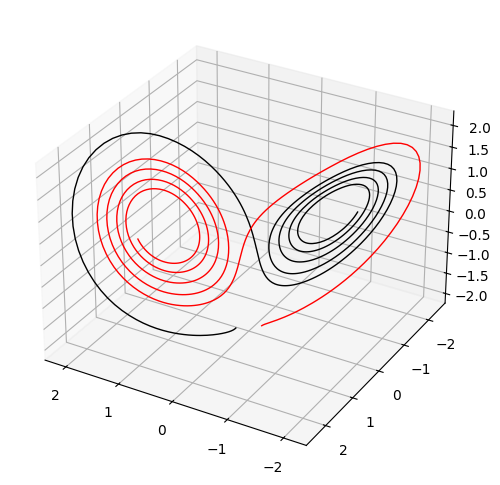

In [288]:
#Normalised Plot
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.plot(xs=data_norm[:, 0,  0], ys=data_norm[:, 0, 1], zs=data_norm[:, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[:, 1, 0], ys=data_norm[:, 1, 1], zs=data_norm[:, 1, 2], color = 'red', linewidth = 1)


ax1.view_init(elev = 30, azim = 120)

plt.show()

# Training Neural ODE

In [289]:
model = Auto_NODE(spatial_dim=3, depth=3, width = 30)
model.network

Sequential(
  (0): Linear(in_features=3, out_features=30, bias=True)
  (1): Tanh()
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): Tanh()
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): Tanh()
  (6): Linear(in_features=30, out_features=3, bias=True)
)

In [290]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

## Single Loop 

In [275]:
#Single training loop
optimizer.zero_grad()
pred_x = odeint(model, training_data_tensor[0, :, :].float(), t_eval_tensor.float(), method='rk4', options={'step_size': dt})

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('')


Total Loss:  tensor(1.2981, grad_fn=<MeanBackward0>)



## Batching 

In [293]:
#### Batching 
# Want output ot be (time, traj, dim)
def batch(data, t, batch_length, num_batch): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).
    '''
    data_length = data.shape[0]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))

        return batch_list, batch_time_list

In [294]:
batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=20, num_batch=5)

In [291]:
training_data_tensor.shape

torch.Size([500, 2, 3])

## Main Training Loop

In [302]:
batch_length = 20
num_batch = 25
num_epochs = 2000
for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[0, :, :], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) #Error is coming from here 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x = odeint(model, training_data_tensor[0, :, :].float(), t_eval_tensor, method='rk4', options={'step_size': dt})
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 1/2000 [00:01<51:16,  1.54s/it]

Epoch 0, Loss: 0.25035160779953003


  5%|▌         | 101/2000 [01:29<28:17,  1.12it/s]

Epoch 100, Loss: 0.18698403239250183


 10%|█         | 201/2000 [02:53<27:29,  1.09it/s]

Epoch 200, Loss: 0.3107297718524933


 15%|█▌        | 301/2000 [04:18<25:29,  1.11it/s]

Epoch 300, Loss: 0.34502169489860535


 20%|██        | 401/2000 [05:56<28:04,  1.05s/it]

Epoch 400, Loss: 0.505881130695343


 25%|██▌       | 501/2000 [07:32<23:19,  1.07it/s]

Epoch 500, Loss: 0.4318121373653412


 30%|███       | 601/2000 [08:58<21:40,  1.08it/s]

Epoch 600, Loss: 0.21023838222026825


 35%|███▌      | 701/2000 [10:23<19:29,  1.11it/s]

Epoch 700, Loss: 0.22885099053382874


 40%|████      | 801/2000 [11:52<20:56,  1.05s/it]

Epoch 800, Loss: 0.1376708298921585


 45%|████▌     | 901/2000 [13:31<19:23,  1.06s/it]

Epoch 900, Loss: 0.2766219973564148


 50%|█████     | 1001/2000 [15:13<17:55,  1.08s/it]

Epoch 1000, Loss: 0.3681682050228119


 55%|█████▌    | 1101/2000 [16:53<15:53,  1.06s/it]

Epoch 1100, Loss: 0.31402409076690674


 60%|██████    | 1201/2000 [18:27<13:09,  1.01it/s]

Epoch 1200, Loss: 0.12456709891557693


 65%|██████▌   | 1301/2000 [19:58<11:37,  1.00it/s]

Epoch 1300, Loss: 0.475186288356781


 70%|███████   | 1401/2000 [21:30<09:51,  1.01it/s]

Epoch 1400, Loss: 0.09084612876176834


 75%|███████▌  | 1501/2000 [23:02<08:24,  1.01s/it]

Epoch 1500, Loss: 0.1372540146112442


 80%|████████  | 1601/2000 [24:33<06:36,  1.01it/s]

Epoch 1600, Loss: 0.35472816228866577


 85%|████████▌ | 1701/2000 [26:05<04:55,  1.01it/s]

Epoch 1700, Loss: 0.09261692315340042


 90%|█████████ | 1801/2000 [27:37<03:17,  1.01it/s]

Epoch 1800, Loss: 0.25764408707618713


 95%|█████████▌| 1901/2000 [29:10<01:42,  1.03s/it]

Epoch 1900, Loss: 0.40119311213493347


100%|██████████| 2000/2000 [30:41<00:00,  1.09it/s]


## Plotting results

Text(0.5, 0, 'Epochs')

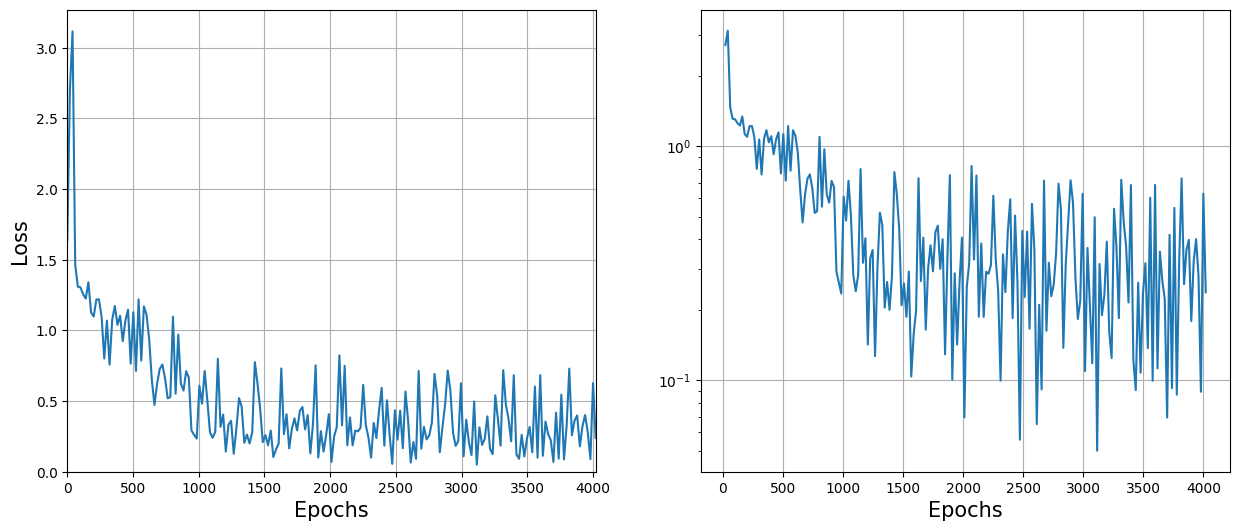

In [303]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

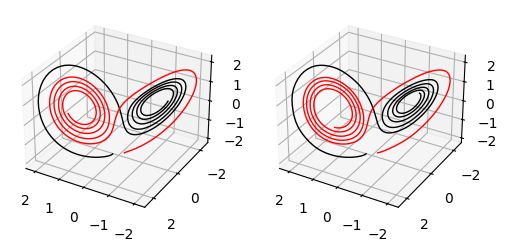

In [305]:
t_Start_pred = 0; t_Final_pred = 5
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})
node_data1 = odeint(model, training_data_tensor[0, 1, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})


#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[:, 0, 0], ys=training_data_tensor[:, 0, 1], zs=training_data_tensor[:, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[:, 1, 0], ys=training_data_tensor[:, 1, 1], zs=training_data_tensor[:, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), 
         color='black', linewidth=1)
ax2.plot(xs=node_data1[:, 0].detach().numpy(), ys=node_data1[:, 1].detach().numpy(), zs=node_data1[:, 2].detach().numpy(), 
         color='red', linewidth=1)

ax2.view_init(elev = 30, azim = 120)


plt.show()

In [306]:
init = torch.tensor([[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]])
init.shape

torch.Size([2, 3])

In [224]:
odeint(model, init, t_eval_pred, method='rk4', options={'step_size': dt}).shape

torch.Size([100, 2, 3])

# Other

In [ ]:


r_list = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5]  # Example r values
initial_conditions = [[1.0, 1.0, 1.0],[-1.0, -1.0, 1.0]] # We use two initial conditions

t_eval = np.linspace(0, 5, 100)
x_data = []
r_data = []

for r in r_list:
    for init in initial_conditions:
        sol = solve_ivp(lorenz, [t_eval[0], t_eval[-1]], init, t_eval=t_eval, args=(10.0, 8/3, r))
        x_data.append(sol.y.T)
        r_data.append(r)

x_data = torch.tensor(np.stack(x_data, axis=1), dtype=torch.float32)  # Tensor of shape [100, 16, 3]
r_data = torch.tensor(r_data, dtype=torch.float32)                     # Tensor of shape [16]  
t_data = torch.tensor(t_eval, dtype=torch.float32)                   # Tensor of shape [100]

# Compute mean and std for x, y, z (over all time steps and trajectories)
xyz_mean = x_data.reshape(-1, 3).mean(dim=0)
xyz_std = x_data.reshape(-1, 3).std(dim=0)

# Compute mean and std for r
r_mean = r_data.mean()
r_std = r_data.std()

# Normalize
x_data_norm = (x_data - xyz_mean) / xyz_std
r_data_norm = (r_data - r_mean) / r_std

print("Generated synthetic data: x_data shape:", x_data.shape, "r_data shape:", r_data.shape)
print("Data was normalized using mean:", xyz_mean, "and std:", xyz_std, "for x, y, z and mean:", r_mean, "and std:", r_std, "for r.")

Generated synthetic data: x_data shape: torch.Size([100, 16, 3]) r_data shape: torch.Size([16])
Data was normalized using mean: tensor([ 0.0000,  0.0000, 11.4681]) and std: tensor([5.7091, 6.0478, 6.9959]) for x, y, z and mean: tensor(13.7500) and std: tensor(5.9161) for r.


In [ ]:
EPOCHS = 2500


#Create dataframes from data
dataframe = Dataframe(t_data, x_data_norm, r_data_norm, variables=3, drivers=1,batchlength=20,batchsize=5)

#Create the model
model=Neuralode(3, 1, parameter_list=r_data_norm, hidden_layers=3,depth_of_layers=16)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(EPOCHS+1)):

        #Get batch list for this epoch
        batch_list,a_list,batch_t=dataframe.get_batch_list()

        for i,batch in enumerate(batch_list):
            
            optimizer.zero_grad()

            #Set bifurcation parameters for batch
            model.parameter_list=a_list[i]
            
            #Do forward passes through network+odesolver
            pred_x = odeint(model, batch[0,:,:].float(), batch_t.float(), method='rk4', options={'step_size': 0.05})
            
            #Calculate losses
            loss = torch.mean(torch.abs(pred_x - batch))
        
            #Optimizer step
            loss.backward()
            optimizer.step()

        if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                model.parameter_list=dataframe.data_a
                pred_x = odeint(model, dataframe.data_x[0,:,:].float(), dataframe.data_t.float(), method='rk4', options={'step_size': 0.05})
                train_loss = torch.mean(torch.abs(pred_x - dataframe.data_x))
                print(f"Epoch: {epoch}  training loss {train_loss.item()}")  

        if epoch%100==0:
            # High-resolution time grid
            t_highres = torch.linspace(t_data[0], t_data[-1], 500).float()

            # Indices for the first initial condition for each r (0, 2, 4, ..., 14)
            indices = list(range(0, x_data_norm.shape[1], 2))

            # Stack initial states and r values for the first initial condition
            init_batch = torch.stack([x_data_norm[0, idx, :] for idx in indices], dim=0)  # [8, 3]
            r_batch = torch.stack([r_data_norm[idx] for idx in indices], dim=0)  # [8, 1]

            model.parameter_list = r_batch  # [8, 1]

            with torch.no_grad():
                pred_traj = odeint(model, init_batch, t_highres, method='rk4', options={'step_size': 0.05})  # [500, 8, 3]
                pred_traj = pred_traj.cpu().numpy()

            fig, axs = plt.subplots(1, len(indices), figsize=(3*len(indices), 3), subplot_kw={'projection': '3d'})
            if len(indices) == 1:
                axs = [axs]

            for i, ax in enumerate(axs):
                line_pred = ax.plot(pred_traj[:, i, 0], pred_traj[:, i, 1], pred_traj[:, i, 2], linewidth=3, label='Prediction')
                scatter_data = ax.scatter(
                    x_data_norm[:, indices[i], 0].cpu(),
                    x_data_norm[:, indices[i], 1].cpu(),
                    x_data_norm[:, indices[i], 2].cpu(),
                    color='black', s=4, alpha=0.6, label='Data'
                )
                ax.set_title(f"r = {r_list[i]}")
                ax.set_xlabel("x")
                ax.set_ylabel("y")
                ax.set_zlabel("z")
            fig.suptitle(f"Neural ODE Predictions for Different r Values (Epoch {epoch})")
            # Create a single legend for the whole figure
            handles = [axs[0].lines[0], axs[0].collections[0]]
            labels = [h.get_label() for h in handles]
            fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1.05))
            img_dir = "training_images"
            os.makedirs(img_dir, exist_ok=True)
            img_path = os.path.join(img_dir, f"epoch_{epoch:04d}.png")
            plt.savefig(img_path)
            plt.close(fig)
                 

  0%|          | 0/2501 [00:00<?, ?it/s]

Epoch: 0  training loss 0.9272240996360779


  1%|          | 21/2501 [00:22<45:59,  1.11s/it] 

Epoch: 20  training loss 0.6994876861572266


  2%|▏         | 41/2501 [00:38<30:25,  1.35it/s]

Epoch: 40  training loss 0.6983481049537659


  2%|▏         | 61/2501 [00:50<24:04,  1.69it/s]

Epoch: 60  training loss 0.69823157787323


  3%|▎         | 81/2501 [01:06<51:21,  1.27s/it]

Epoch: 80  training loss 0.6938324570655823


  4%|▍         | 100/2501 [01:20<26:43,  1.50it/s]

Epoch: 100  training loss 0.6985571384429932


  5%|▍         | 121/2501 [01:36<28:07,  1.41it/s]

Epoch: 120  training loss 0.6087066531181335


  6%|▌         | 141/2501 [01:50<25:09,  1.56it/s]

Epoch: 140  training loss 0.6064201593399048


  6%|▋         | 161/2501 [02:04<29:09,  1.34it/s]

Epoch: 160  training loss 0.6102409958839417


  7%|▋         | 181/2501 [02:18<26:02,  1.49it/s]

Epoch: 180  training loss 0.6092478632926941


  8%|▊         | 200/2501 [02:33<30:43,  1.25it/s]

Epoch: 200  training loss 0.6177563667297363


  9%|▉         | 221/2501 [02:51<30:03,  1.26it/s]

Epoch: 220  training loss 0.6146557331085205


 10%|▉         | 241/2501 [03:07<27:44,  1.36it/s]

Epoch: 240  training loss 0.6173315644264221


 10%|█         | 261/2501 [03:20<25:57,  1.44it/s]

Epoch: 260  training loss 0.6152761578559875


 11%|█         | 281/2501 [03:35<26:35,  1.39it/s]

Epoch: 280  training loss 0.6133214235305786


 12%|█▏        | 300/2501 [03:47<23:52,  1.54it/s]

Epoch: 300  training loss 0.6037387847900391


 13%|█▎        | 321/2501 [04:04<27:18,  1.33it/s]

Epoch: 320  training loss 0.6003873944282532


 14%|█▎        | 341/2501 [04:17<22:44,  1.58it/s]

Epoch: 340  training loss 0.5960296392440796


 14%|█▍        | 361/2501 [04:31<28:04,  1.27it/s]

Epoch: 360  training loss 0.5619140863418579


 15%|█▌        | 381/2501 [04:47<26:47,  1.32it/s]

Epoch: 380  training loss 0.5956272482872009


 16%|█▌        | 400/2501 [05:02<26:31,  1.32it/s]

Epoch: 400  training loss 0.598122239112854


 17%|█▋        | 421/2501 [05:22<26:50,  1.29it/s]

Epoch: 420  training loss 0.5484551787376404


 18%|█▊        | 441/2501 [05:38<25:50,  1.33it/s]

Epoch: 440  training loss 0.5926723480224609


 18%|█▊        | 461/2501 [05:53<25:22,  1.34it/s]

Epoch: 460  training loss 0.6437126398086548


 19%|█▉        | 481/2501 [06:08<24:45,  1.36it/s]

Epoch: 480  training loss 0.6926131248474121


 20%|█▉        | 500/2501 [06:21<23:18,  1.43it/s]

Epoch: 500  training loss 0.6385028958320618


 21%|██        | 521/2501 [06:40<30:58,  1.07it/s]

Epoch: 520  training loss 0.5504083037376404


 22%|██▏       | 541/2501 [06:55<23:54,  1.37it/s]

Epoch: 540  training loss 0.4933762550354004


 22%|██▏       | 561/2501 [07:11<25:31,  1.27it/s]

Epoch: 560  training loss 0.5711346864700317


 23%|██▎       | 581/2501 [07:27<26:35,  1.20it/s]

Epoch: 580  training loss 0.4803350865840912


 24%|██▍       | 600/2501 [07:41<24:32,  1.29it/s]

Epoch: 600  training loss 0.6821287870407104


 25%|██▍       | 621/2501 [08:01<27:01,  1.16it/s]

Epoch: 620  training loss 0.42814838886260986


 26%|██▌       | 641/2501 [08:17<26:30,  1.17it/s]

Epoch: 640  training loss 0.4737849831581116


 26%|██▋       | 661/2501 [08:32<22:16,  1.38it/s]

Epoch: 660  training loss 0.46126988530158997


 27%|██▋       | 681/2501 [08:46<22:05,  1.37it/s]

Epoch: 680  training loss 0.39603468775749207


 28%|██▊       | 700/2501 [08:59<21:37,  1.39it/s]

Epoch: 700  training loss 0.4106437861919403


 29%|██▉       | 721/2501 [09:18<30:05,  1.01s/it]

Epoch: 720  training loss 0.3498340845108032


 30%|██▉       | 741/2501 [09:32<20:42,  1.42it/s]

Epoch: 740  training loss 0.37849628925323486


 30%|███       | 761/2501 [09:46<20:13,  1.43it/s]

Epoch: 760  training loss 0.44808363914489746


 31%|███       | 781/2501 [09:59<18:58,  1.51it/s]

Epoch: 780  training loss 0.4393932521343231


 32%|███▏      | 800/2501 [10:12<18:36,  1.52it/s]

Epoch: 800  training loss 0.4700607359409332


 33%|███▎      | 821/2501 [10:30<21:36,  1.30it/s]

Epoch: 820  training loss 0.5166442394256592


 34%|███▎      | 841/2501 [10:44<20:45,  1.33it/s]

Epoch: 840  training loss 0.38709741830825806


 34%|███▍      | 861/2501 [10:59<19:17,  1.42it/s]

Epoch: 860  training loss 0.4429502487182617


 35%|███▌      | 881/2501 [11:13<19:42,  1.37it/s]

Epoch: 880  training loss 0.43200546503067017


 36%|███▌      | 900/2501 [11:26<18:38,  1.43it/s]

Epoch: 900  training loss 0.4451739490032196


 37%|███▋      | 921/2501 [11:45<20:46,  1.27it/s]

Epoch: 920  training loss 0.43396249413490295


 38%|███▊      | 941/2501 [11:59<19:27,  1.34it/s]

Epoch: 940  training loss 0.43852031230926514


 38%|███▊      | 961/2501 [12:15<20:45,  1.24it/s]

Epoch: 960  training loss 0.4649379551410675


 39%|███▉      | 981/2501 [12:30<18:11,  1.39it/s]

Epoch: 980  training loss 0.43296197056770325


 40%|███▉      | 1000/2501 [12:43<16:26,  1.52it/s]

Epoch: 1000  training loss 0.43256905674934387


 41%|████      | 1021/2501 [13:00<20:31,  1.20it/s]

Epoch: 1020  training loss 0.4585833251476288


 42%|████▏     | 1041/2501 [13:15<17:46,  1.37it/s]

Epoch: 1040  training loss 0.3584756851196289


 42%|████▏     | 1061/2501 [13:29<16:54,  1.42it/s]

Epoch: 1060  training loss 0.3200947642326355


 43%|████▎     | 1081/2501 [13:43<17:03,  1.39it/s]

Epoch: 1080  training loss 0.3025835454463959


 44%|████▍     | 1100/2501 [13:56<16:13,  1.44it/s]

Epoch: 1100  training loss 0.2873772978782654


 45%|████▍     | 1121/2501 [14:14<17:35,  1.31it/s]

Epoch: 1120  training loss 0.23456349968910217


 46%|████▌     | 1141/2501 [14:27<14:58,  1.51it/s]

Epoch: 1140  training loss 0.29726436734199524


 46%|████▋     | 1161/2501 [14:40<15:06,  1.48it/s]

Epoch: 1160  training loss 0.23407500982284546


 47%|████▋     | 1181/2501 [14:53<15:27,  1.42it/s]

Epoch: 1180  training loss 0.27682608366012573


 48%|████▊     | 1200/2501 [15:05<13:37,  1.59it/s]

Epoch: 1200  training loss 0.2797064781188965


 49%|████▉     | 1221/2501 [15:21<14:00,  1.52it/s]

Epoch: 1220  training loss 0.2217467725276947


 50%|████▉     | 1241/2501 [15:34<13:48,  1.52it/s]

Epoch: 1240  training loss 0.24613726139068604


 50%|█████     | 1261/2501 [15:47<13:14,  1.56it/s]

Epoch: 1260  training loss 0.259811133146286


 51%|█████     | 1281/2501 [16:02<16:13,  1.25it/s]

Epoch: 1280  training loss 0.23181764781475067


 52%|█████▏    | 1300/2501 [16:15<12:44,  1.57it/s]

Epoch: 1300  training loss 0.20784920454025269


 53%|█████▎    | 1321/2501 [16:30<12:52,  1.53it/s]

Epoch: 1320  training loss 0.2206210345029831


 54%|█████▎    | 1341/2501 [16:44<13:56,  1.39it/s]

Epoch: 1340  training loss 0.22591198980808258


 54%|█████▍    | 1361/2501 [16:58<14:39,  1.30it/s]

Epoch: 1360  training loss 0.19584710896015167


 55%|█████▌    | 1381/2501 [17:15<15:35,  1.20it/s]

Epoch: 1380  training loss 0.20010152459144592


 56%|█████▌    | 1400/2501 [17:29<11:58,  1.53it/s]

Epoch: 1400  training loss 0.2150418609380722


 57%|█████▋    | 1421/2501 [17:47<13:22,  1.35it/s]

Epoch: 1420  training loss 0.21925918757915497


 58%|█████▊    | 1441/2501 [18:01<11:18,  1.56it/s]

Epoch: 1440  training loss 0.22561562061309814


 58%|█████▊    | 1461/2501 [18:14<12:09,  1.43it/s]

Epoch: 1460  training loss 0.217299222946167


 59%|█████▉    | 1481/2501 [18:27<10:45,  1.58it/s]

Epoch: 1480  training loss 0.17593656480312347


 60%|█████▉    | 1500/2501 [18:38<10:03,  1.66it/s]

Epoch: 1500  training loss 0.209213986992836


 61%|██████    | 1521/2501 [18:53<10:41,  1.53it/s]

Epoch: 1520  training loss 0.18909484148025513


 62%|██████▏   | 1541/2501 [19:06<09:46,  1.64it/s]

Epoch: 1540  training loss 0.20204521715641022


 62%|██████▏   | 1561/2501 [19:20<14:25,  1.09it/s]

Epoch: 1560  training loss 0.16254009306430817


 63%|██████▎   | 1581/2501 [19:36<10:32,  1.46it/s]

Epoch: 1580  training loss 0.22972190380096436


 64%|██████▍   | 1600/2501 [19:49<09:52,  1.52it/s]

Epoch: 1600  training loss 0.1303107887506485


 65%|██████▍   | 1621/2501 [20:05<10:58,  1.34it/s]

Epoch: 1620  training loss 0.1995547115802765


 66%|██████▌   | 1641/2501 [20:18<09:48,  1.46it/s]

Epoch: 1640  training loss 0.178297758102417


 66%|██████▋   | 1661/2501 [20:32<10:28,  1.34it/s]

Epoch: 1660  training loss 0.21783851087093353


 67%|██████▋   | 1681/2501 [20:45<09:13,  1.48it/s]

Epoch: 1680  training loss 0.17808665335178375


 68%|██████▊   | 1700/2501 [20:58<08:57,  1.49it/s]

Epoch: 1700  training loss 0.1953333169221878


 69%|██████▉   | 1721/2501 [21:15<10:55,  1.19it/s]

Epoch: 1720  training loss 0.18197695910930634


 70%|██████▉   | 1741/2501 [21:31<09:52,  1.28it/s]

Epoch: 1740  training loss 0.20598191022872925


 70%|███████   | 1761/2501 [21:45<08:41,  1.42it/s]

Epoch: 1760  training loss 0.18894079327583313


 71%|███████   | 1781/2501 [22:00<08:32,  1.40it/s]

Epoch: 1780  training loss 0.1636619120836258


 72%|███████▏  | 1800/2501 [22:14<07:43,  1.51it/s]

Epoch: 1800  training loss 0.1647685170173645


 73%|███████▎  | 1821/2501 [22:30<08:23,  1.35it/s]

Epoch: 1820  training loss 0.1653001755475998


 74%|███████▎  | 1841/2501 [22:46<08:58,  1.23it/s]

Epoch: 1840  training loss 0.13382954895496368


 74%|███████▍  | 1861/2501 [23:00<07:43,  1.38it/s]

Epoch: 1860  training loss 0.15541495382785797


 75%|███████▌  | 1881/2501 [23:15<07:20,  1.41it/s]

Epoch: 1880  training loss 0.14378949999809265


 76%|███████▌  | 1900/2501 [23:28<07:00,  1.43it/s]

Epoch: 1900  training loss 0.14400312304496765


 77%|███████▋  | 1921/2501 [23:46<07:44,  1.25it/s]

Epoch: 1920  training loss 0.1537727266550064


 78%|███████▊  | 1941/2501 [24:01<06:49,  1.37it/s]

Epoch: 1940  training loss 0.16875742375850677


 78%|███████▊  | 1961/2501 [24:15<06:31,  1.38it/s]

Epoch: 1960  training loss 0.12803222239017487


 79%|███████▉  | 1981/2501 [24:30<06:43,  1.29it/s]

Epoch: 1980  training loss 0.15813706815242767


 80%|███████▉  | 2000/2501 [24:48<07:08,  1.17it/s]

Epoch: 2000  training loss 0.1413678377866745


 81%|████████  | 2021/2501 [25:03<05:19,  1.50it/s]

Epoch: 2020  training loss 0.1412702053785324


 82%|████████▏ | 2041/2501 [25:16<04:52,  1.57it/s]

Epoch: 2040  training loss 0.19132745265960693


 82%|████████▏ | 2061/2501 [25:28<04:31,  1.62it/s]

Epoch: 2060  training loss 0.18108835816383362


 83%|████████▎ | 2081/2501 [25:50<11:02,  1.58s/it]

Epoch: 2080  training loss 0.1270724982023239


 84%|████████▍ | 2100/2501 [26:15<08:28,  1.27s/it]

Epoch: 2100  training loss 0.14989648759365082


 85%|████████▍ | 2121/2501 [26:44<08:20,  1.32s/it]

Epoch: 2120  training loss 0.19794686138629913


 86%|████████▌ | 2141/2501 [27:08<07:34,  1.26s/it]

Epoch: 2140  training loss 0.1111576110124588


 86%|████████▋ | 2161/2501 [27:33<07:19,  1.29s/it]

Epoch: 2160  training loss 0.19068121910095215


 87%|████████▋ | 2181/2501 [27:58<06:37,  1.24s/it]

Epoch: 2180  training loss 0.17082618176937103


 88%|████████▊ | 2200/2501 [28:22<06:32,  1.30s/it]

Epoch: 2200  training loss 0.14751966297626495


 89%|████████▉ | 2221/2501 [28:51<06:10,  1.32s/it]

Epoch: 2220  training loss 0.13457824289798737


 90%|████████▉ | 2241/2501 [29:16<05:39,  1.31s/it]

Epoch: 2240  training loss 0.14487633109092712


 90%|█████████ | 2261/2501 [29:34<03:02,  1.32it/s]

Epoch: 2260  training loss 0.18584288656711578


 91%|█████████ | 2281/2501 [29:48<02:21,  1.56it/s]

Epoch: 2280  training loss 0.12712958455085754


 92%|█████████▏| 2300/2501 [30:01<02:21,  1.42it/s]

Epoch: 2300  training loss 0.14402566850185394


 93%|█████████▎| 2321/2501 [30:18<02:14,  1.34it/s]

Epoch: 2320  training loss 0.1720445454120636


 94%|█████████▎| 2341/2501 [30:32<01:48,  1.47it/s]

Epoch: 2340  training loss 0.11061198264360428


 94%|█████████▍| 2361/2501 [30:45<01:37,  1.44it/s]

Epoch: 2360  training loss 0.12828797101974487


 95%|█████████▌| 2381/2501 [30:59<01:22,  1.45it/s]

Epoch: 2380  training loss 0.1196935772895813


 96%|█████████▌| 2400/2501 [31:12<01:06,  1.51it/s]

Epoch: 2400  training loss 0.11186748743057251


 97%|█████████▋| 2421/2501 [31:28<00:57,  1.38it/s]

Epoch: 2420  training loss 0.2165064960718155


 98%|█████████▊| 2441/2501 [31:41<00:39,  1.53it/s]

Epoch: 2440  training loss 0.10549937188625336


 98%|█████████▊| 2461/2501 [31:54<00:25,  1.58it/s]

Epoch: 2460  training loss 0.13557040691375732


 99%|█████████▉| 2481/2501 [32:07<00:13,  1.48it/s]

Epoch: 2480  training loss 0.12937794625759125


100%|█████████▉| 2500/2501 [32:19<00:00,  1.50it/s]

Epoch: 2500  training loss 0.1955251395702362


100%|██████████| 2501/2501 [32:21<00:00,  1.29it/s]


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.integrate import solve_ivp

# Define r values and time grid
r_values = np.arange(5, 30.1, 2.5)
t_highres = np.linspace(float(t_data[0]), float(100), 5000)
init_cond = [1.0, 1.0, 1.0]  # unnormalized initial condition

# Precompute true system trajectories
true_traj = []
for r in r_values:
    sol = solve_ivp(
        lambda t, y: [
            10.0 * (y[1] - y[0]),
            y[0] * (r - y[2]) - y[1],
            y[0] * y[1] - (8/3) * y[2]
        ],
        [t_highres[0], t_highres[-1]],
        init_cond,
        t_eval=t_highres
    )
    # Normalize the true trajectory using xyz_mean and xyz_std
    traj_norm = (sol.y.T - xyz_mean.numpy()) / xyz_std.numpy()
    true_traj.append(traj_norm)
true_traj = np.stack(true_traj, axis=0)

init_batch = x_data_norm[0, 0, :].repeat(len(r_values), 1)  # [num_r, 3]
r_batch = torch.tensor([(r - r_mean.item()) / r_std.item() for r in r_values], dtype=torch.float32)  # [num_r, 1]
model.parameter_list = r_batch

with torch.no_grad():
    pred_x = odeint(model, init_batch, torch.tensor(t_highres, dtype=torch.float32), method='rk4', options={'step_size': 0.01})  # [500, num_r, 3]
    pred_x = pred_x.cpu().numpy()

def plot_both_trajectories(r_idx):
    r = r_values[r_idx]
    traj_pred = pred_x[:, r_idx, :]
    traj_true = true_traj[r_idx]
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})

    # Predicted
    axs[0].plot(traj_pred[:, 0], traj_pred[:, 1], traj_pred[:, 2], color="#1c3066")
    axs[0].set_title(f"Model Prediction (r={r})")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[0].set_zlabel("z")
    axs[0].set_xlim(-4, 4)
    axs[0].set_ylim(-4, 4)
    axs[0].set_zlim(-1, 4)

    # True
    axs[1].plot(traj_true[:, 0], traj_true[:, 1], traj_true[:, 2], color="#1b6942")
    axs[1].set_title(f"True System (r={r})")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")
    axs[1].set_zlabel("z")
    axs[1].set_xlim(-4, 4)
    axs[1].set_ylim(-4, 4)
    axs[1].set_zlim(-1, 4)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

interact(plot_both_trajectories, r_idx=IntSlider(min=0, max=len(r_values)-1, step=1, value=0))